In [49]:
import pandas as pd
import numpy as np
import pyreadstat
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2


##### 0.- Cargar datos

In [3]:
df_inicial, meta = pyreadstat.read_sav('Casen 2017.sav')
type(df_inicial)
type(meta)

pyreadstat._readstat_parser.metadata_container

#### 1.- Pre procesamiento

In [4]:
'''

Variables utilizadas para construir el modelo de redes neuronales para estimar categoría de ingresos

1.- Identificación 
edad
zona - Rural o urbano
tot_hog - Total de hogares en la vivienda
tot_per - Total de personas (incluye sdpa)
ecivil - estado civil

2.- Dificultades de la persona
h10a - ¿Tiene dificultad para ver incluso si lleva lentes?
h10b - ¿Tiene dificultad para oír incluso si utiliza un audífono?
h10c - ¿Tiene dificultad para caminar o para subir escaleras?
h10d - ¿Tiene dificultad para recordar o para concentrarse?
h10e - ¿Tiene dificultad para el cuidado personal, como asearse o vestirse? 
h10f - ¿Tiene dificultad para comunicarse, por ejemplo, dificultad para comprender o ser comprendido por otros? 

3.- Educación
e6a - ¿Cuál fue el nivel educacional más alto alcanzado o el nivel educacional actual?
e7_subarea - ¿Cuál es el nombre de la carrera o programa de estudios? (Cod sub-área)
e8 - ¿En qué tipo de institución realizó su educación superior?

4.- Trabajo
oficio1 - ¿Cuál es su ocupación u oficio? (1 dígito)
o23 - ¿Cuántas personas trabajan en total en ese negocio o empresa o institución?

o1 - o1. La semana pasada, ¿trabajó al menos una hora, sin considerar los quehaceres del hogar?
o12 - o12. ¿Su trabajo o negocio principal es de tipo:
o15 - o15. En su trabajo o negocio principal, ¿usted trabaja como?
o16 - o16. En su trabajo principal, ¿qué tipo de contrato o acuerdo de trabajo tiene?
o18 - o18. Según su contrato de trabajo, ¿su jornada de trabajo normal es…?
o29 - o29. ¿Cotizó durante el mes pasado en algún sistema previsional..?

5.- Ingresos
ch1 -  Chequeo de situación ocupacional.
y1 - Mes pasado Salario líquido trabajo principal
y3a - ¿Recibió el mes pasado ingresos por horas extras...? (monto)
y3b - ¿recibió el mes pasado ingresos por comisiones...? (monto)

y2_dias - y2_dias. Días pactados con empleador
y2_hrs - y2_hrs. Horas pactadas con empleador

6.- Salud
s4 - ¿Cuántos hijos nacidos vivos ha tenido en su vida?
s5 - ¿Qué edad tenía cuando nació su primer hijo?
s13 - En una escala de 1 a 7, ¿Qué nota le pondría a su estado de salud actual?

7.- Identidades
r1a - ¿Cuál es la nacionalidad?
r3 - Pueblos indígenas, ¿pertenece usted o es descendiente de alguno de ellos?

'''

'\n1.- Identificación \nedad\nzona - Rural o urbano\ntot_hog - Total de hogares en la vivienda\ntot_per - Total de personas (incluye sdpa)\necivil - estado civil\n\n2.- Dificultades de la persona\nh10a - ¿Tiene dificultad para ver incluso si lleva lentes?\nh10b - ¿Tiene dificultad para oír incluso si utiliza un audífono?\nh10c - ¿Tiene dificultad para caminar o para subir escaleras?\nh10d - ¿Tiene dificultad para recordar o para concentrarse?\nh10e - ¿Tiene dificultad para el cuidado personal, como asearse o vestirse? \nh10f - ¿Tiene dificultad para comunicarse, por ejemplo, dificultad para comprender o ser comprendido por otros? \n\n3.- Educación\ne6a - ¿Cuál fue el nivel educacional más alto alcanzado o el nivel educacional actual?\ne7_subarea - ¿Cuál es el nombre de la carrera o programa de estudios? (Cod sub-área)\ne8 - ¿En qué tipo de institución realizó su educación superior?\n\n4.- Trabajo\noficio1 - ¿Cuál es su ocupación u oficio? (1 dígito)\no23 - ¿Cuántas personas trabajan en

In [5]:
variables = ["edad" ,"zona", "tot_hog", "tot_per", "ecivil", "e6a", "e7_subarea", "e8", 
"oficio1", "o23", "o1","o12", "o15", "o16", "o18", "o29", "y2_dias","y2_hrs","ch1", "y1", 
"y3a", "y3b", "s4", "s5", "s13", "r1a", "r3", "h10a", "h10b", "h10c", "h10d", "h10e", "h10f"] 

In [6]:
df = df_inicial[variables]

In [7]:
''' Se filtran las variables seleccionadas y luego los trabajadores que tienen una situación de (1) Asalariado y (2) Patrón o empleador/ 
Trabajador Cuenta Propia '''

df = df[variables]
df = df[(df.ch1 == 1) | (df.ch1 == 2)]

In [8]:
''' Se eliminan los valores Nan de las variables de ingresos'''

df = df.dropna(subset=["y1", "y3a", "y3b"])

In [9]:
''' La variable dependiente se contruye a partir de las variables de ingresos líquidos (y1), comisiones (y3a) más ingresos por comisiones (y3b)'''

df["Y"] = df["y1"]+df["y3a"]+df["y3b"]
df = df.drop(["y1","y3a","y3b"], axis=1)

<AxesSubplot:xlabel='Variables', ylabel='% Missing Values'>

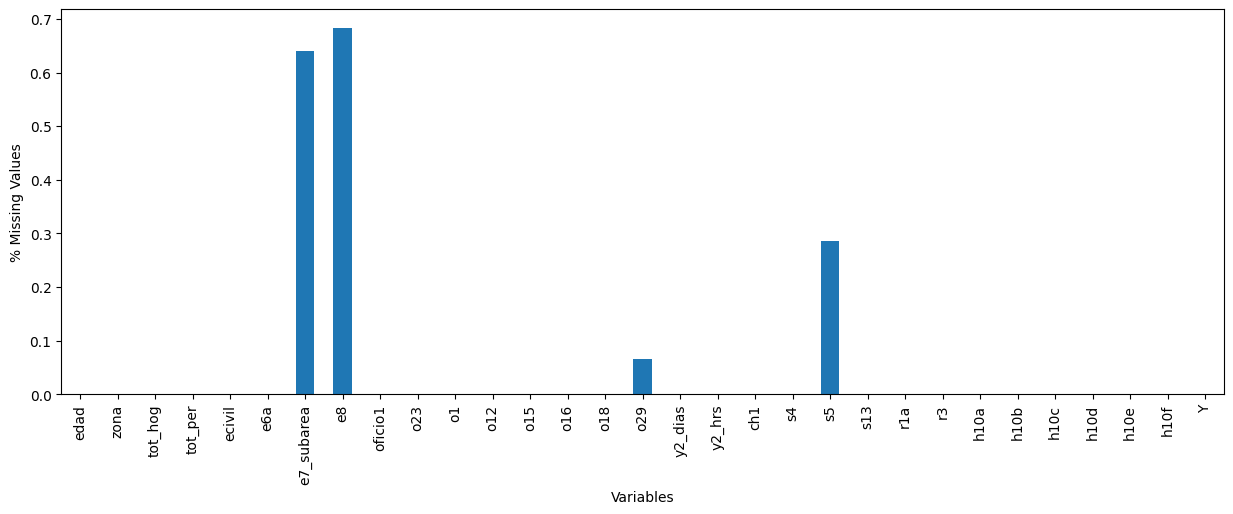

In [10]:
''' Se revisan los porcentajes de valores Nan para cada variable y se evalúa cómo abordarlos''' 

df.isnull().mean().plot(kind='bar', xlabel='Variables', ylabel='% Missing Values', figsize= (15,5))

<AxesSubplot:xlabel='Variables', ylabel='% Missing Values'>

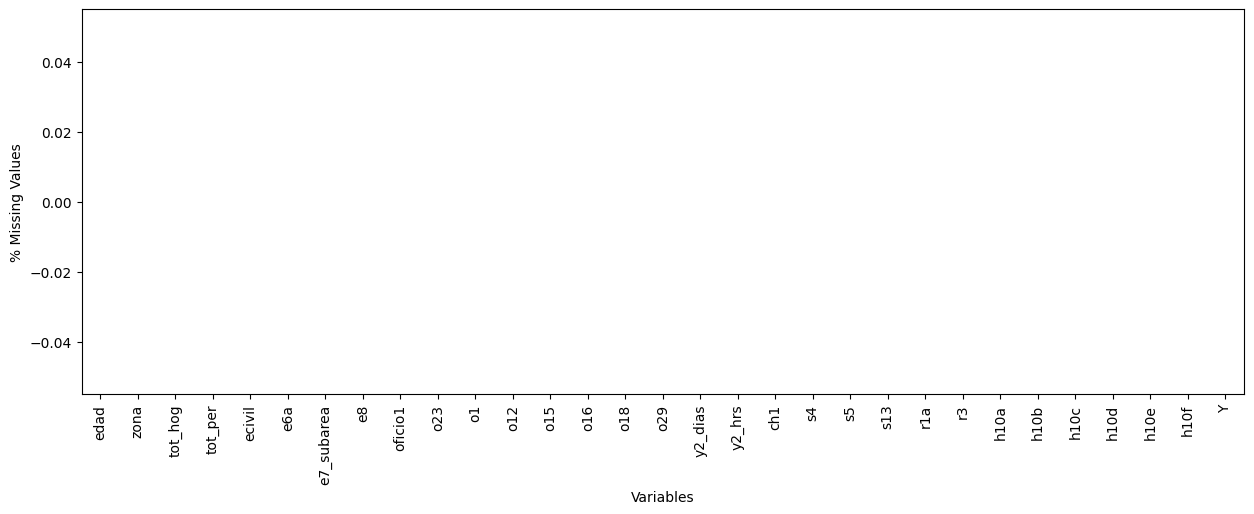

In [11]:
''' Los valores Nan se encuentran en varibales cualitaivas. Estos son reemplazados por las constante "sin_respuesta" ''' 

imputer_categorical = SimpleImputer(strategy = "constant", fill_value= "sin_respuesta")
imputer_categorical.fit(df)
imputer_feature = imputer_categorical.transform(df)
df = pd.DataFrame(data=imputer_feature , columns=df.columns)
df.isnull().mean().plot(kind='bar', xlabel='Variables', ylabel='% Missing Values', figsize= (15,5))


<AxesSubplot:>

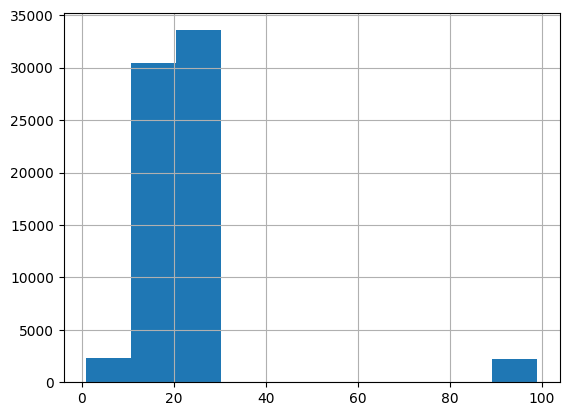

In [12]:
"""Gráfico con los días de trabajo pactados"""

df["y2_dias"].hist()


In [13]:
"""Se eliminan los registros de personas con días de trabajo pactados superior a 31 días"""

df = df[df.y2_dias < 32]

<AxesSubplot:>

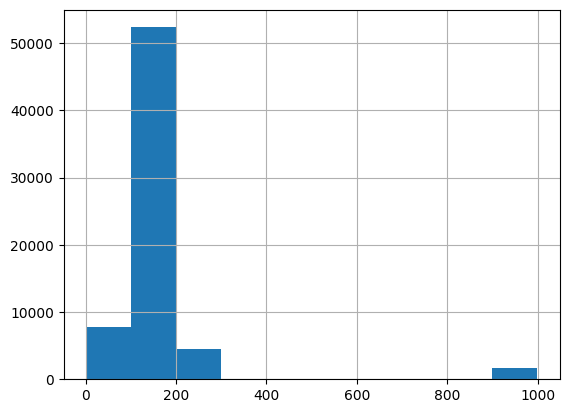

In [14]:
"""Gráfico con el número de horas mensuales pactadas con el empleador """

df["y2_hrs"].hist()

In [48]:
""" Se filtran las personas con menos de 400 horas al mes de trabajo comprometidas"""

df = df[df.y2_hrs < 400]

In [16]:
''' La vatriable s5 - ¿Qué edad tenía cuando nació su primer hijo? se tranforma en una variabe discreta, 
porque en los casos que no hay respuesta el registro es nan y cuando la persona no recordaba la edad se indica el valor 99 '''

for i in range(df.shape[1]):
    if type(df["s5"][i])==str:
        df["s5"][i] = 1000

df["s5"] = df["s5"].replace(["sin_respuesta"], 10000)

df["s5"] = pd.cut(df['s5'], [0, 15, 20, 25, 30, 35, 40, 70, 1001], 
                                 labels=['0-15', '16-20', '21-25', '26-30','31-35','36-40','41-70',"sin_respuesta"])

In [17]:
''' Las variables categoricas de tranforan a dummies''' 

variables_dummies = [ "zona", "ecivil","e6a","e7_subarea","e8","oficio1","ch1", "s13", "s5", "o23", "h10a", "r1a", "r3",
"h10b", "h10c", "h10d", "h10e", "h10f", "o1", "o12", "o15", "o16", "o18", "o29"]

df_dummies = pd.get_dummies(df[variables_dummies], drop_first = True)
df = df.drop(variables_dummies, axis=1)
df = pd.concat([df, df_dummies], axis=1)

c:\Users\felip\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [18]:
df

,edad,tot_hog,tot_per,y2_dias,y2_hrs,s4,Y,zona_2.0,ecivil_2.0,ecivil_3.0,...,o18_4.0,o18_9.0,o29_2.0,o29_3.0,o29_4.0,o29_5.0,o29_6.0,o29_7.0,o29_9.0,o29_sin_respuesta
0,21.0,1.0,1.0,30.0,216.0,0.0,200000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,24.0,1.0,2.0,30.0,192.0,0.0,270000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,28.0,1.0,2.0,30.0,192.0,0.0,300000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,26.0,1.0,3.0,30.0,192.0,1.0,320000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59.0,1.0,4.0,30.0,160.0,3.0,270000.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68620,56.0,1.0,1.0,30.0,180.0,0.0,1160000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68622,59.0,1.0,3.0,30.0,180.0,2.0,521000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68626,28.0,1.0,1.0,30.0,190.0,1.0,360000.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
68628,57.0,1.0,1.0,15.0,120.0,3.0,120000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
''' Las personas que registran edad 0 son eliminadas del análisis'''

df = df[df.edad != 0]

In [20]:
''' Las personas que no recuerdan cuantos hijos nacidos vivos tuvieron, se registran con el número 99, por lo que son eliminadas'''

df = df [df.s4 != 99]

In [21]:
''' Se usan los datos de las personas con sueldos menores a 2.5 millones, pues gran parte de las personas se ubican 
dentro de este rango y hay outlier con ingresos superior a 30 millones'''

df = df[df.Y<=2400000 ][df.Y>1]

C:\Users\felip\AppData\Local\Temp\ipykernel_13492\3337078072.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.Y<=2400000 ][df.Y>1]


In [22]:
''' Se separa el dataframe entre variables dependientes e independientes, y luego entre datos de train y test '''

Y = df["Y"]
X = df.drop(["Y"], axis = 1)

In [23]:
''' la variable independiente se transforma en una variable cuantitativa para los rangos de ingresos '''

Y_labels = pd.cut(Y, [0, 216000, 432000, 2400000], 
                                 labels=['1', '2', '3'])

<AxesSubplot:>

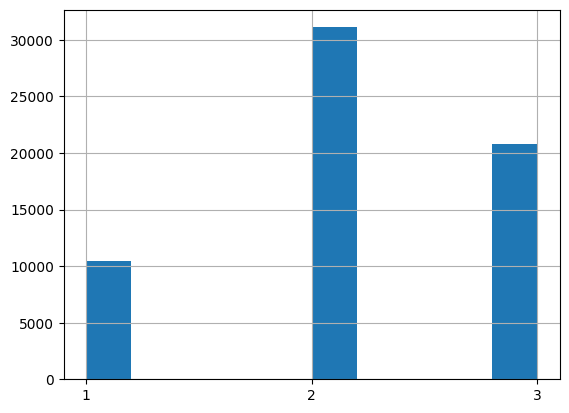

In [24]:
Y_labels.hist()

In [25]:
''' Las variables independientes son estandarizadas'''

scaler = StandardScaler() 
X = scaler.fit_transform(X) 

In [26]:
Y = pd.to_numeric(Y_labels)

In [27]:
'''  Dataframe se divide en datos de entrenamiento y testeo''' 

x_train, x_test = train_test_split(X, train_size=0.85, random_state=0)
y_train, y_test = train_test_split(Y, train_size=0.85, random_state=0)


In [28]:
''' Over sampling a la categorias con menor frecuencia '''

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_train_OS, y_train_OS = ros.fit_resample(x_train, y_train)


In [29]:
x_train_OS = np.asarray(x_train).astype('float32')
y_train_OS = np.asarray(y_train).astype('int64')
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [30]:
y_test = pd.get_dummies(y_test)
y_train = pd.get_dummies(y_train)
y_train_OS = pd.get_dummies(y_train_OS)

In [31]:
y_train.shape

(53019, 3)

In [32]:
x_train.shape

(53019, 158)

In [33]:
x_test.shape

(9357, 158)

#### Modelo de deep learnig

In [34]:
model = Sequential(name='Ingresos')
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       input_shape=(x_train.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       name='Hidden_02'))
model.add(layers.Dense(units=3,
                       activation='softmax', 
                       name='Output'))


model.compile(optimizer= Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "Ingresos"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_01 (Dense)            (None, 10)                1590      
_________________________________________________________________
Hidden_02 (Dense)            (None, 10)                110       
_________________________________________________________________
Output (Dense)               (None, 3)                 33        
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x= x_train, y=y_train,  
                    validation_split=0.3,
                    shuffle=True,
                    epochs=1000, 
                    batch_size=10000)

Epoch 1/1000
4/4 [==============================] - 2s 43ms/step - loss: 1.3222 - accuracy: 0.3077 - val_loss: 1.2767 - val_accuracy: 0.3323
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2558 - accuracy: 0.3449 - val_loss: 1.2179 - val_accuracy: 0.3680
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1978 - accuracy: 0.3853 - val_loss: 1.1668 - val_accuracy: 0.4090
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1474 - accuracy: 0.4269 - val_loss: 1.1229 - val_accuracy: 0.4481
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1041 - accuracy: 0.4672 - val_loss: 1.0853 - val_accuracy: 0.4854
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0668 - accuracy: 0.5024 - val_loss: 1.0529 - val_accuracy: 0.5164
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0345 - accuracy: 0.5336 - val_loss: 1.0250 - val_accuracy: 0.5411
Epoch 8/1000


In [ ]:
model = Sequential(name='Ingresos')
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       input_shape=(x_train.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       name='Hidden_02'))
model.add(layers.Dense(units=3,
                       activation='softmax', 
                       name='Output'))


model.compile(optimizer= Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

In [36]:
def plot_history(history, width=12, height=6):
    
  keys = list(history.history.keys())
  epoch = range(1, len(history.epoch) +1)

  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

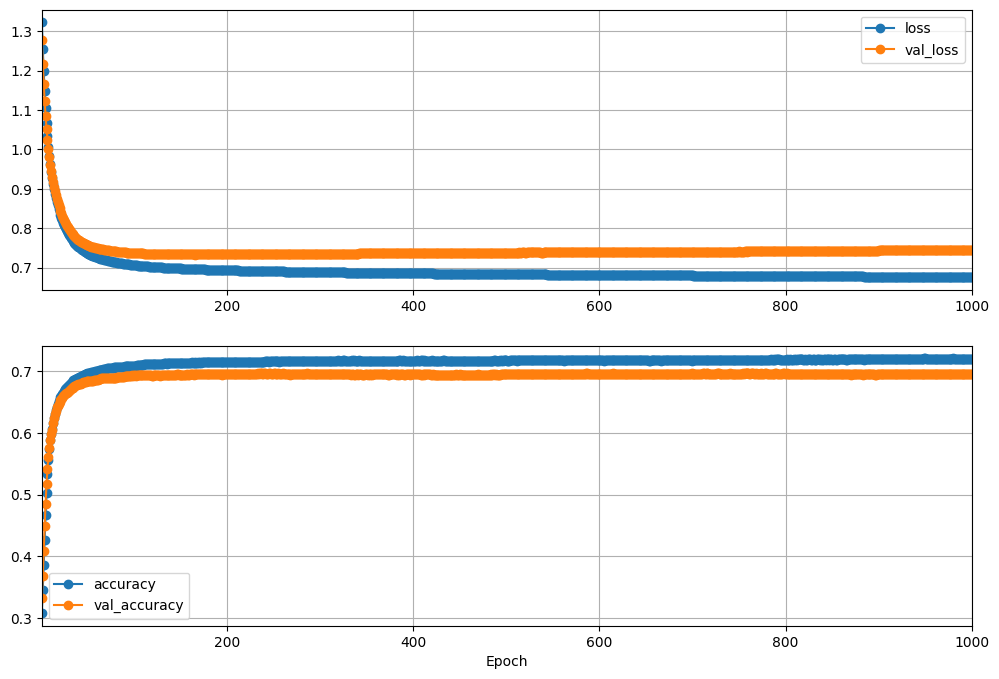

In [37]:
plot_history(history, width=12, height=8)

In [38]:
model = Sequential(name='Ingresos')
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       input_shape=(x_train.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dense(units=10, 
                       activation='relu', 
                       name='Hidden_02'))
model.add(layers.Dense(units=3,
                       activation='softmax', 
                       name='Output'))


model.compile(optimizer= Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "Ingresos"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_01 (Dense)            (None, 10)                1590      
_________________________________________________________________
Hidden_02 (Dense)            (None, 10)                110       
_________________________________________________________________
Output (Dense)               (None, 3)                 33        
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
_________________________________________________________________


In [40]:
# MODELO FINAL

History = model.fit(x= x_train_OS, y=y_train_OS,  
                    validation_split=0.3,
                    shuffle=True,
                    epochs=100, 
                    batch_size=10000)

Epoch 1/100
4/4 [==============================] - 1s 291ms/step - loss: 0.6738 - accuracy: 0.7222 - val_loss: 0.7405 - val_accuracy: 0.6923
Epoch 2/100
4/4 [==============================] - 1s 263ms/step - loss: 0.6733 - accuracy: 0.7218 - val_loss: 0.7402 - val_accuracy: 0.6929
Epoch 3/100
4/4 [==============================] - 1s 270ms/step - loss: 0.6728 - accuracy: 0.7224 - val_loss: 0.7399 - val_accuracy: 0.6929
Epoch 4/100
4/4 [==============================] - 1s 264ms/step - loss: 0.6724 - accuracy: 0.7228 - val_loss: 0.7397 - val_accuracy: 0.6932
Epoch 5/100
4/4 [==============================] - 1s 256ms/step - loss: 0.6720 - accuracy: 0.7230 - val_loss: 0.7395 - val_accuracy: 0.6929
Epoch 6/100
4/4 [==============================] - 1s 265ms/step - loss: 0.6718 - accuracy: 0.7238 - val_loss: 0.7394 - val_accuracy: 0.6934
Epoch 7/100
4/4 [==============================] - 1s 255ms/step - loss: 0.6716 - accuracy: 0.7243 - val_loss: 0.7394 - val_accuracy: 0.6932
Epoch 8/100
4

In [41]:
prediction = model.predict(x_test)
prediction_class = np.argmax(prediction, axis=-1) + 1



In [43]:
y_test_ = []

for i in range( y_test.shape[0]):
    for j in range( y_test.shape[1]):
        if y_test.iloc[i,j] == 1:
            y_test_.append(j+1)

y_test_ = np.array(y_test_)

In [44]:
confusion_matrix(y_true=y_test_, y_pred=prediction_class)

array([[ 608,  712,  250],
       [ 215, 3784,  602],
       [  36,  998, 2152]], dtype=int64)

In [45]:
print(classification_report(y_true=y_test_, y_pred=prediction_class))

              precision    recall  f1-score   support

           1       0.71      0.39      0.50      1570
           2       0.69      0.82      0.75      4601
           3       0.72      0.68      0.70      3186

    accuracy                           0.70      9357
   macro avg       0.70      0.63      0.65      9357
weighted avg       0.70      0.70      0.69      9357

